In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/clean_risk_data.csv')
df.drop(df.columns[0],axis=1,inplace=True)
df.head()

,activeloan_coalt,applicationamount,applicationprice,avgbetweenapplications,avgbetweenapprovedapplications,avgextensions,avgloanterm,countapplicationsafterlastloanclose,countrejectedapplications,countrejectedapplicationsafterlastloanclose,...,housetype_UNKNOWN,identificationtype_IDENTITY_IN_CITY,identificationtype_IDENTITY_IN_HOUSE,identificationtype_IDENTITY_IN_STREET,identificationtype_IDENTITY_IN_UNIVERSE,identificationtype_LASTNAME_IN_HOUSE,identificationtype_NOT_IDENTIFIED,score_partialdecision_GREEN,score_partialdecision_RED,score_partialdecision_YELLOW
0,0,2500,402.11,0.00,0.0,0.0,0.0,1,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0,600,0.00,0.00,0.0,0.0,30.0,1,0,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0,500,0.00,0.00,0.0,0.0,0.0,1,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0,500,0.00,0.01,0.0,0.0,0.0,2,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,300,0.00,0.00,0.0,0.0,0.0,1,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


**Problem Statement**: the simulated dataset is from a bank with various indicators of borrowers' demographic characteristics, liquidity, credit rating as well as specific information about the loan packages. The task is to find out what patterns do loan defaulters might share, both qualitatively and quantitatively, and how to identify them using the given data.


- **Northstar metrics:**
  - *Average default amount* (= application amount/#defaults): measures the average loss incurred from each default
  - *Default ratio* (= #defaults/#total): the ratio of borrowers defaulting in a particular demographic group
  - *Total amount ratio* (= sum of application amount for all defaults/sum of application amount for all loans): the total loss from defaults as a percentage of the total application amounts in that group

- The reason why we might want to normalize these metrics is because even though the absolute number of default cases within a particular demographic group is important and cautions should be taken against high number of defaults, we should still categorize a group as profitable as long as most of the loans in that group are still well-performing.
  
- More specifically, we will look at these metrics for different qualitative indicators including gender, decision, value, housetype, identification type, employment status and score of partial decision. Lacking further explanations, it is difficult to understand these indicators perfectly. However, personal research suggests that they could be interpreted in the following way.
  - **Partial decision**: the intermediate risk assessment level assigned to a borrower, might be automatic based on some ML model or basic decision-making.
  - **Decision**: after reviewing the partial decision initially assigned and supplementing with human assessment, this is likely the final credit scoring/risk assessment level assigned to a borrower. Quickly viewing the data, it appears that these 2 types of decision are not too dependent on each other and a green partial decision can be revoked to red afterwards while a red partial decision can also be reassigned to green. In particular, green and yellow partial decisions will most likely remain the same whereas a red partial decision will turn green. Also, in absolute numbers, the majority of given decisions are green. Great for the bank!
  - **Value**: since there are only 2 values for this category - Adult or Unknown, it is likely an indicator of the legal age of the borrower.
- Note: This analysis won't make use of feature-engineering which is admittedly often very useful in creating more informative features in the particular domain.

In [ ]:
decision_df = pd.merge(df.groupby(['score_partialdecision','decision']).size().rename('count'),df.groupby('score_partialdecision').size().rename('total_count'),left_index=True, right_index=True)
decision_df['ratio'] = decision_df['count']/decision_df['total_count']
decision_df

count  total_count     ratio
score_partialdecision decision                              
partialdecisionGREEN  GREEN      9106         9370  0.971825
                      RED         112         9370  0.011953
                      YELLOW      152         9370  0.016222
partialdecisionRED    GREEN       261          342  0.763158
                      RED          74          342  0.216374
                      YELLOW        7          342  0.020468
partialdecisionYELLOW GREEN        78          213  0.366197
                      RED           5          213  0.023474
                      YELLOW      130          213  0.610329

Reconvert one-hot encodings into text

In [ ]:
categorical_cols = ['decision_GREEN', 'decision_RED',
       'decision_YELLOW', 'gender_FEMALE', 'gender_MALE', 'value_ADULT',
       'value_UNKNOWN', 'housetype_COMPANY_ONLY',
       'housetype_PRIVATE_ONLY', 'housetype_REGULAR',
       'housetype_SHARED_USAGE', 'housetype_UNKNOWN',
       'identificationtype_IDENTITY_IN_CITY',
       'identificationtype_IDENTITY_IN_HOUSE',
       'identificationtype_IDENTITY_IN_STREET',
       'identificationtype_IDENTITY_IN_UNIVERSE',
       'identificationtype_LASTNAME_IN_HOUSE',
       'identificationtype_NOT_IDENTIFIED', 'score_partialdecision_GREEN',
       'score_partialdecision_RED', 'score_partialdecision_YELLOW']

In [ ]:
unique_categorical = pd.Series([col.split('_')[0] for col in categorical_cols]).unique()

In [ ]:
for cat in unique_categorical:
  print(cat)
  if cat == 'score':
    cat = 'score_partialdecision'
    df[cat] = df.filter(like=cat).idxmax(axis=1).apply(
      lambda x: x.split('_')[-1] if len(x.split('_')) ==2 else ''.join(x.split('_')[1:]))
  else:
    df[cat] = df.filter(like=cat).idxmax(axis=1).apply(
        lambda x: x.split('_')[-1] if len(x.split('_')) ==2 else ''.join(x.split('_')[1:]))

decision
gender
value
housetype
identificationtype
score


In [ ]:
df.drop(categorical_cols,axis=1,inplace=True)

In [ ]:
df.rename(columns={'month':'application_month'},inplace=True)

In [ ]:
df['application_month'] = df['application_month'].astype(str)

Function to calculate statistics of interest and plot them

In [ ]:
# metric: application amount per default (average default amount), average default rate, total defaults, won't touch other quantitative amounts for now
# dimension: the ones above + employment status + time

def stat_compute(feature):
  stat_df = pd.concat([df.groupby(['year','application_month',feature])['TARGET'].sum().rename('total_default'),df.groupby(['year','application_month',feature])['TARGET'].size().rename('total_count')],axis=1)
  stat_df['sum_amount_default'] = df[df['TARGET']==1].groupby(['year','application_month',feature])['applicationamount'].sum()
  stat_df = pd.merge(stat_df, df.groupby(['year','application_month',feature])['applicationamount'].sum().rename('sum_amount_total'),left_index=True, right_index=True)
  stat_df['sum_ratio_default'] = stat_df['sum_amount_default']/stat_df['sum_amount_total']
  stat_df['max_amount'] = df[df['TARGET']==1].groupby(['year','application_month',feature])['applicationamount'].max()
  stat_df['default_ratio'] = stat_df['total_default']/stat_df['total_count']
  stat_df['avg_default_amount'] = stat_df['sum_amount_default']/stat_df['total_default']
  return round(stat_df.reset_index().drop('year',axis=1),3)

In [ ]:
def stat_plot(feature,thres=6):
  n_feat = df[feature].nunique()
  ncols = min(n_feat, thres)
  nrows = int(n_feat/thres) if n_feat > 6 else 1
  stat_df = stat_compute(feature)
  fig, axes1 = plt.subplots(nrows,ncols,sharey=True,figsize=(3*ncols,4*nrows))
  axes1 = axes1.flatten()
  axes2 = axes1
  for i, feat in enumerate(df[feature].unique()):
    sns.barplot(stat_df[stat_df[feature]==feat],x='application_month',y='avg_default_amount',ax=axes1[i],color='lightblue')
    axes2[i] = axes1[i].twinx()
    axes2[i].set_ylim(0,1)
    sns.lineplot(stat_df[stat_df[feature]==feat], x='application_month',y='default_ratio',ax=axes2[i],color='red')
    axes1[i].set_title(feat)
    if i ==0:
      axes2[i].set_ylabel('')
    else:
      axes1[i].set_ylabel('')
  plt.tight_layout()
  return round(stat_df,3);

Overall statistics by loan application time

In [ ]:
overall_df = pd.concat([df.groupby(['year','application_month'])['TARGET'].sum().rename('total_default'),df.groupby(['year','application_month'])['TARGET'].size().rename('total_count')],axis=1)
overall_df['sum_amount_default'] = df[df['TARGET']==1].groupby(['year','application_month'])['applicationamount'].sum()
overall_df = pd.merge(overall_df, df.groupby(['year','application_month'])['applicationamount'].sum().rename('sum_amount_total'),left_index=True, right_index=True)
overall_df['sum_ratio_default'] = overall_df['sum_amount_default']/overall_df['sum_amount_total']
overall_df['default_ratio'] = overall_df['total_default']/overall_df['total_count']
overall_df['avg_default_amount'] = overall_df['sum_amount_default']/overall_df['total_default']
overall_df['max_amount'] = df[df['TARGET']==1].groupby(['year','application_month'])['applicationamount'].max()
round(overall_df,3)

total_default  total_count  sum_amount_default  \
year application_month                                                   
2020 10                           530         2497              604400   
     11                           276         1434              378200   
     12                           459         1968              595900   
2021 1                            457         1878              493300   
     2                            415         1659              523400   
     3                            114          489              132400   

                        sum_amount_total  sum_ratio_default  default_ratio  \
year application_month                                                       
2020 10                          2706000              0.223          0.212   
     11                          1650900              0.229          0.192   
     12                          2321500              0.257          0.233   
2021 1                           1943300              0.254          0.243   
     2                           1984200              0.264          0.250   
     3                            541700              0.244          0.233   

                        avg_default_amount  max_amount  
year application_month                                  
2020 10                           1140.377        3000  
     11                           1370.290        3000  
     12                           1298.257        3000  
2021 1                            1079.431        3000  
     2                            1261.205        3000  
     3                            1161.404        3000

This table tells us several important things about how the bank at issue is doing. The bank approves a monthly average of over 1800-1900 loans with October 2020 giving out a number doubling that. The default ratio always stays consistently at 20% of all borrowings, with an average amount of over 1000 per default case. The total default amount is always about 22-25% of the entire loan porfolio with 2021 experiencing much higher losses than the year prior.

A few notable observations: although October 2020 and January 2021 report some of the highest numbers of defaults in absolute number, the average amount per default is in the lower range at approximately 1150. On the contrary, the bank suffers quite substantial losses in terms of average default amount in the immediately following month of November, tabulating 1370 which is the highest number registered among all monthly units despite recording the fewest default cases both in absolute and relative measures, at 276 and 19% respectively. Finally, it appears that this bank caps a maximum amount on lendables at 3000, which needs to be investigated further given that this is not likely market standard.

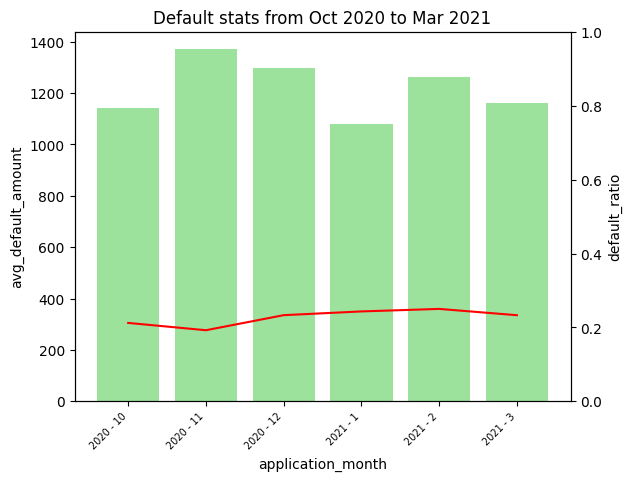

In [ ]:
fig, ax1 = plt.subplots()
sns.barplot(overall_df, x='application_month', y='avg_default_amount',ax=ax1,color='lightgreen')
plt.xticks(range(len(overall_df)),[f"{year} - {month}" for year, month in overall_df.index],rotation=45, ha='right',fontsize=7)
ax2 = ax1.twinx()
ax2.set_ylim(0,1)
sns.lineplot(overall_df,x='application_month',y='default_ratio',ax=ax2,color='red')
plt.title('Default stats from Oct 2020 to Mar 2021');

Analysis by qualitative indicators

,application_month,gender,total_default,total_count,sum_amount_default,sum_amount_total,sum_ratio_default,max_amount,default_ratio,avg_default_amount
0,10,FEMALE,237,1131,274400,1263500,0.217,3000,0.210,1157.806
1,10,MALE,293,1366,330000,1442500,0.229,3000,0.214,1126.280
2,11,FEMALE,117,703,151200,839700,0.180,3000,0.166,1292.308
3,11,MALE,159,731,227000,811200,0.280,3000,0.218,1427.673
4,12,FEMALE,188,881,260100,1082300,0.240,3000,0.213,1383.511
5,12,MALE,271,1087,335800,1239200,0.271,3000,0.249,1239.114
6,1,FEMALE,200,871,250500,986600,0.254,3000,0.230,1252.500
7,1,MALE,257,1007,242800,956700,0.254,3000,0.255,944.747
8,2,FEMALE,140,699,182900,901300,0.203,3000,0.200,1306.429
9,2,MALE,275,960,340500,1082900,0.314,3000,0.286,1238.182


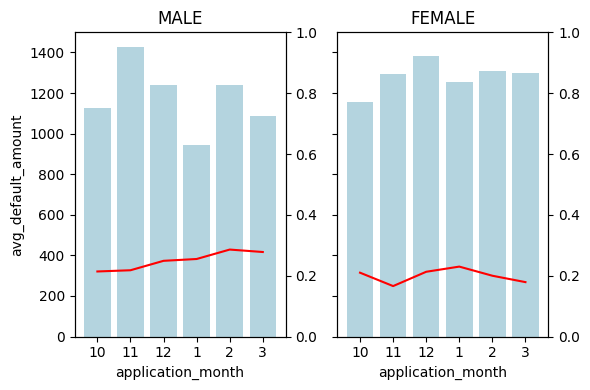

In [ ]:
stat_plot('gender')

The default ratio of female is lower across all months but mostly higher in average amount. This suggests that although female customers take out fewer loans compared to their male counterparts, the value of each loan is often higher.

,application_month,decision,total_default,total_count,sum_amount_default,sum_amount_total,sum_ratio_default,max_amount,default_ratio,avg_default_amount
0,10,GREEN,498,2357,575300,2561400,0.225,3000,0.211,1155.221
1,10,RED,17,72,14100,71900,0.196,2000,0.236,829.412
2,10,YELLOW,15,68,15000,72700,0.206,2500,0.221,1000.000
3,11,GREEN,264,1381,357800,1584500,0.226,3000,0.191,1355.303
4,11,RED,5,20,3800,19300,0.197,1000,0.250,760.000
5,11,YELLOW,7,33,16600,47100,0.352,3000,0.212,2371.429
6,12,GREEN,428,1870,566700,2218900,0.255,3000,0.229,1324.065
7,12,RED,12,28,12600,32800,0.384,3000,0.429,1050.000
8,12,YELLOW,19,70,16600,69800,0.238,2500,0.271,873.684
9,1,GREEN,435,1802,474500,1873700,0.253,3000,0.241,1090.805


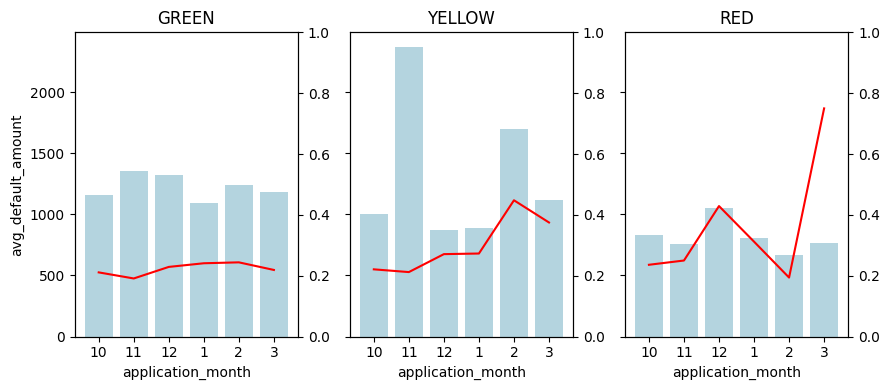

In [ ]:
stat_plot('decision')

By final decision of credit scoring, green has the lowest default ratio as expected, although the difference with yellow and red in the first two months is not remarkable. However, from Dec 2020, the default ratios of yellow and red decisions start to climb for the former and actually soar substantially for the latter to over 40%. This number decreases temporarily in the red decision case before peaking at almost 80% in the last month in the dataset.

However, when we look at other absolute metrics such as total or average default amount, green decisions still lead ahead by a huge margin with the exception of a few months for yellow decisions. This could simply reflect the fact that a customer could borrow a lot because she has green rating, and as she borrows high, she will default high if she does.

We might want to pay attention to the beginning period of a year because applications made around this time tend to be default loans at a much higher rate than applications made in other time of the year. This suggests that time-aware features such as month or year might be relevant in detecting defaults (our feature selection using Boruta does not include these 2, which could be due to the fact that the algorithm can't work well in class imbalance cases).

,application_month,housetype,total_default,total_count,sum_amount_default,sum_amount_total,sum_ratio_default,max_amount,default_ratio,avg_default_amount
0,10,COMPANYONLY,20,78,18400.0,87700,0.210,1300.0,0.256,920.000
1,10,PRIVATEONLY,48,339,53200.0,356600,0.149,3000.0,0.142,1108.333
2,10,REGULAR,10,49,11500.0,49600,0.232,3000.0,0.204,1150.000
3,10,SHAREDUSAGE,358,1629,412000.0,1788000,0.230,3000.0,0.220,1150.838
4,10,UNKNOWN,94,402,109300.0,424100,0.258,3000.0,0.234,1162.766
5,11,COMPANYONLY,12,38,16100.0,56800,0.283,3000.0,0.316,1341.667
6,11,PRIVATEONLY,40,223,51000.0,252800,0.202,3000.0,0.179,1275.000
7,11,REGULAR,2,30,1200.0,29700,0.040,600.0,0.067,600.000
8,11,SHAREDUSAGE,177,907,242600.0,1025200,0.237,3000.0,0.195,1370.621
9,11,UNKNOWN,45,236,67300.0,286400,0.235,3000.0,0.191,1495.556


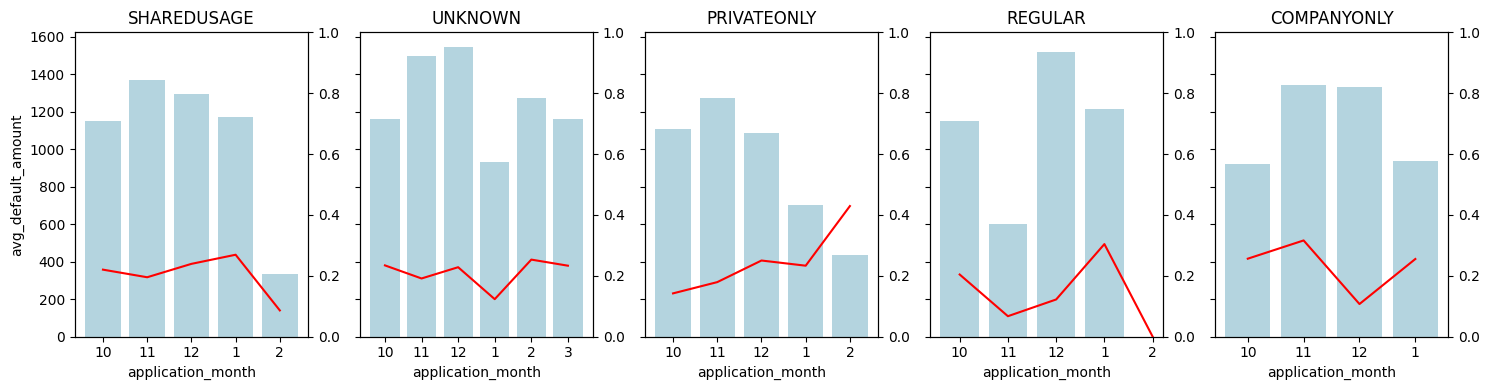

In [ ]:
stat_plot('housetype')

By house type, there doesn't seem to be any distinct difference with respect to the average default amount. Most of the house types maintain a consistent default ratio at more than 20%, except for privateonly and regular in the first two months of 2021 peaking at around 40%.

,application_month,value,total_default,total_count,sum_amount_default,sum_amount_total,sum_ratio_default,max_amount,default_ratio,avg_default_amount
0,10,ADULT,122,623,140800,690200,0.204,3000,0.196,1154.098
1,10,UNKNOWN,408,1874,463600,2015800,0.230,3000,0.218,1136.275
2,11,ADULT,58,360,88900,446000,0.199,3000,0.161,1532.759
3,11,UNKNOWN,218,1074,289300,1204900,0.240,3000,0.203,1327.064
4,12,ADULT,75,437,100400,570100,0.176,3000,0.172,1338.667
5,12,UNKNOWN,384,1531,495500,1751400,0.283,3000,0.251,1290.365
6,1,ADULT,103,486,120900,543700,0.222,3000,0.212,1173.786
7,1,UNKNOWN,354,1392,372400,1399600,0.266,3000,0.254,1051.977
8,2,ADULT,77,377,105800,495000,0.214,3000,0.204,1374.026
9,2,UNKNOWN,338,1282,417600,1489200,0.280,3000,0.264,1235.503


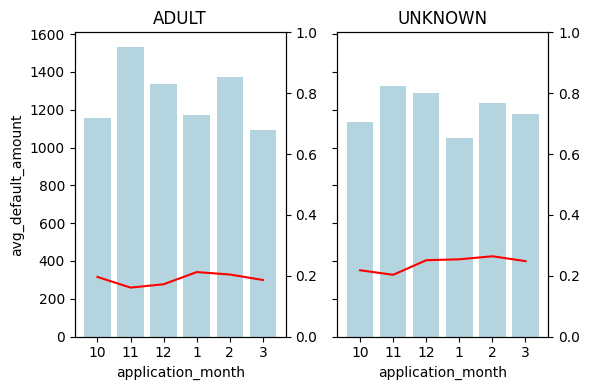

In [ ]:
stat_plot('value')

,application_month,identificationtype,total_default,total_count,sum_amount_default,sum_amount_total,sum_ratio_default,max_amount,default_ratio,avg_default_amount
0,10,IDENTITYINCITY,11,67,14100.0,67700,0.208,3000.0,0.164,1281.818
1,10,IDENTITYINHOUSE,120,594,145000.0,703400,0.206,3000.0,0.202,1208.333
2,10,IDENTITYINSTREET,4,40,8300.0,49600,0.167,3000.0,0.100,2075.000
3,10,IDENTITYINUNIVERSE,269,1488,328400.0,1611400,0.204,3000.0,0.181,1220.818
4,10,LASTNAMEINHOUSE,32,85,27700.0,80300,0.345,2500.0,0.376,865.625
5,10,NOTIDENTIFIED,94,223,80900.0,193600,0.418,3000.0,0.422,860.638
6,11,IDENTITYINCITY,8,30,9500.0,35500,0.268,2000.0,0.267,1187.500
7,11,IDENTITYINHOUSE,58,323,80700.0,414200,0.195,3000.0,0.180,1391.379
8,11,IDENTITYINSTREET,9,28,10800.0,36600,0.295,3000.0,0.321,1200.000
9,11,IDENTITYINUNIVERSE,177,971,255900.0,1097600,0.233,3000.0,0.182,1445.763


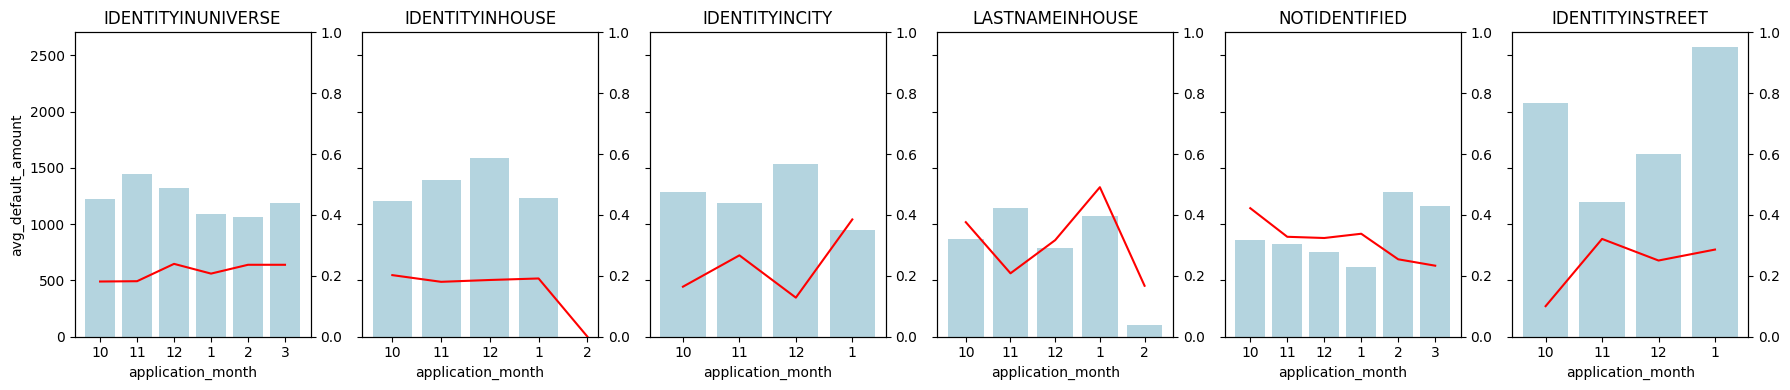

In [ ]:
stat_plot('identificationtype')

,application_month,score_partialdecision,total_default,total_count,sum_amount_default,sum_amount_total,sum_ratio_default,max_amount,default_ratio,avg_default_amount
0,10,partialdecisionGREEN,508,2433,584400.0,2644500,0.221,3000.0,0.209,1150.394
1,10,partialdecisionRED,12,30,9600.0,25800,0.372,2000.0,0.400,800.000
2,10,partialdecisionYELLOW,10,34,10400.0,35700,0.291,2500.0,0.294,1040.000
3,11,partialdecisionGREEN,272,1419,368600.0,1632400,0.226,3000.0,0.192,1355.147
4,11,partialdecisionRED,0,3,NaN,2800,NaN,NaN,0.000,NaN
5,11,partialdecisionYELLOW,4,12,9600.0,15700,0.611,3000.0,0.333,2400.000
6,12,partialdecisionGREEN,444,1936,583400.0,2289800,0.255,3000.0,0.229,1313.964
7,12,partialdecisionRED,6,9,8200.0,12700,0.646,3000.0,0.667,1366.667
8,12,partialdecisionYELLOW,9,23,4300.0,19000,0.226,800.0,0.391,477.778
9,1,partialdecisionGREEN,444,1842,482600.0,1911200,0.253,3000.0,0.241,1086.937


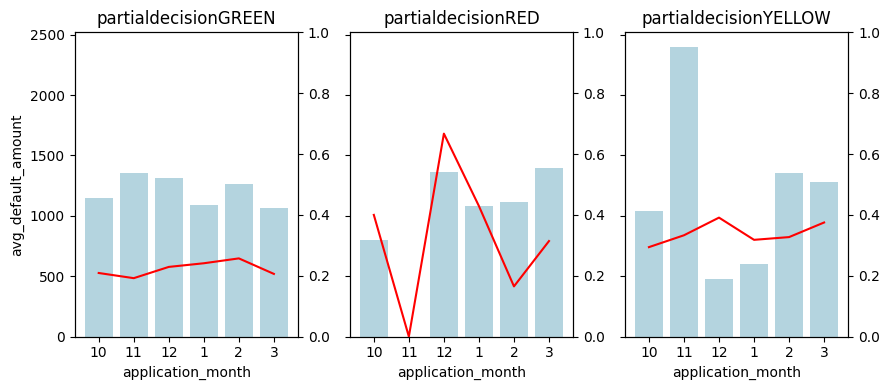

In [ ]:
stat_plot('score_partialdecision')

,application_month,employmentstatus,total_default,total_count,sum_amount_default,sum_amount_total,sum_ratio_default,max_amount,default_ratio,avg_default_amount
0,10,0,13,58,11700.0,59200,0.198,1300.0,0.224,900.000
1,10,1,261,1235,306100.0,1404700,0.218,3000.0,0.211,1172.797
2,10,2,79,407,91900.0,403600,0.228,3000.0,0.194,1163.291
3,10,3,40,181,39000.0,160500,0.243,3000.0,0.221,975.000
4,10,4,17,125,26900.0,174000,0.155,3000.0,0.136,1582.353
...,...,...,...,...,...,...,...,...,...,...
62,3,6,0,1,NaN,500,NaN,NaN,0.000,NaN
63,3,7,2,23,1700.0,27900,0.061,900.0,0.087,850.000
64,3,8,0,14,NaN,16900,NaN,NaN,0.000,NaN
65,3,10,12,30,12500.0,31800,0.393,3000.0,0.400,1041.667


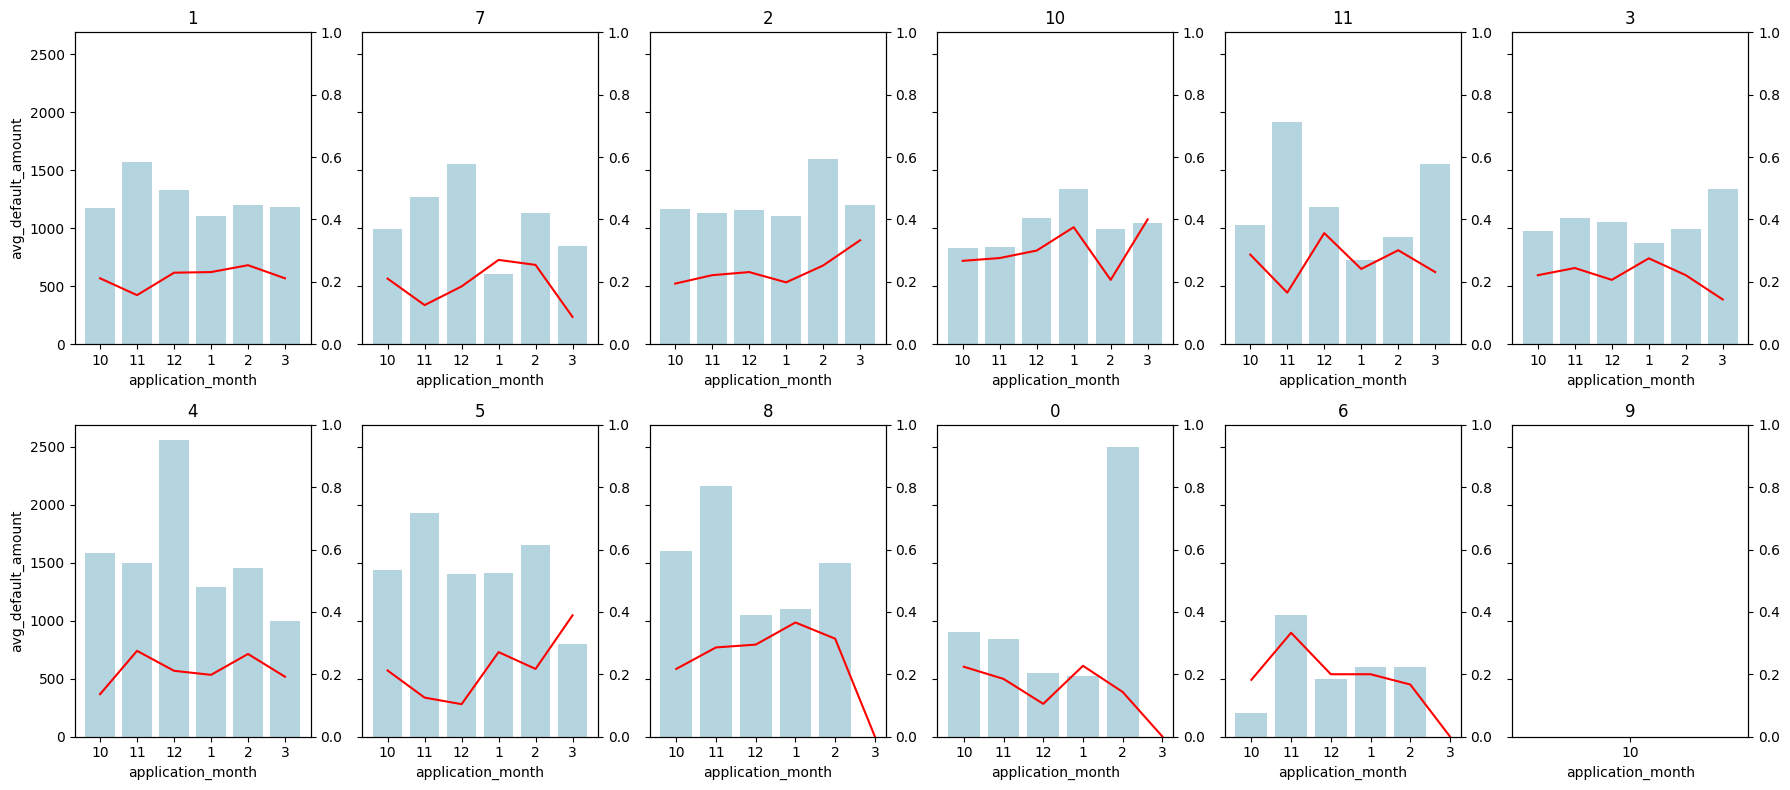

In [ ]:
stat_plot('employmentstatus')

Analysis by quantitative indicators: choose several that are most highly correlated to TARGET

In [ ]:
# numeric features: focus on one of the swo_ind_same_pesel_different_lender_count_unique, providerscount, masterriskstatus_no_negative_history, swo_ind_loans_number_p0_plus, paidobligationscount, countrejectedapplications, averagepaiddebt
corr_df = df.select_dtypes(include=[int,float]).corr()['TARGET'].apply(abs).sort_values(ascending=False)[1:21].reset_index()
corr_df

,index,TARGET
0,swo_ind_same_pesel_different_lender_count_uniq...,0.177572
1,swo_ind_same_pesel_different_lender_count_uniq...,0.174729
2,providerscount,0.170389
3,swo_ind_same_pesel_applications_count_p0_30,0.167648
4,swo_ind_same_pesel_applications_count_p0_7,0.165214
5,swo_ind_same_pesel_different_lender_count_uniq...,0.144709
6,masterriskstatus_no_negative_history,0.143878
7,swo_ind_loans_number_p0_plus,0.140302
8,swo_ind_same_pesel_different_lender_count_uniq...,0.139209
9,paidobligationscount,0.134162


In [ ]:
corr_df['type'] = corr_df['index'].apply(lambda x: df[x].dtype)

In [ ]:
# check types
corr_df

,index,TARGET,type
0,swo_ind_same_pesel_different_lender_count_uniq...,0.177572,int64
1,swo_ind_same_pesel_different_lender_count_uniq...,0.174729,int64
2,providerscount,0.170389,float64
3,swo_ind_same_pesel_applications_count_p0_30,0.167648,int64
4,swo_ind_same_pesel_applications_count_p0_7,0.165214,int64
5,swo_ind_same_pesel_different_lender_count_uniq...,0.144709,int64
6,masterriskstatus_no_negative_history,0.143878,int64
7,swo_ind_loans_number_p0_plus,0.140302,int64
8,swo_ind_same_pesel_different_lender_count_uniq...,0.139209,int64
9,paidobligationscount,0.134162,float64


Function to plot statistics of numeric indicators

In [ ]:
def numeric_plot(feature):
  fig, ax = plt.subplots(1,2,figsize=(12,5))
  log_scale = True if df[feature].max() > 20 else False
  sns.histplot(df,x=feature,log_scale=log_scale,hue='TARGET',multiple='dodge',ax=ax[0])
  sns.boxplot(df, y='TARGET',x=feature, orient='h', hue='TARGET',ax=ax[1])
  # sns.histplot(df,x=feature,hue='TARGET',element='step',cumulative=True,fill=False, log_scale=False, stat='probability', common_norm=False, ax=ax[1])
  ax[1].set_xlabel('');

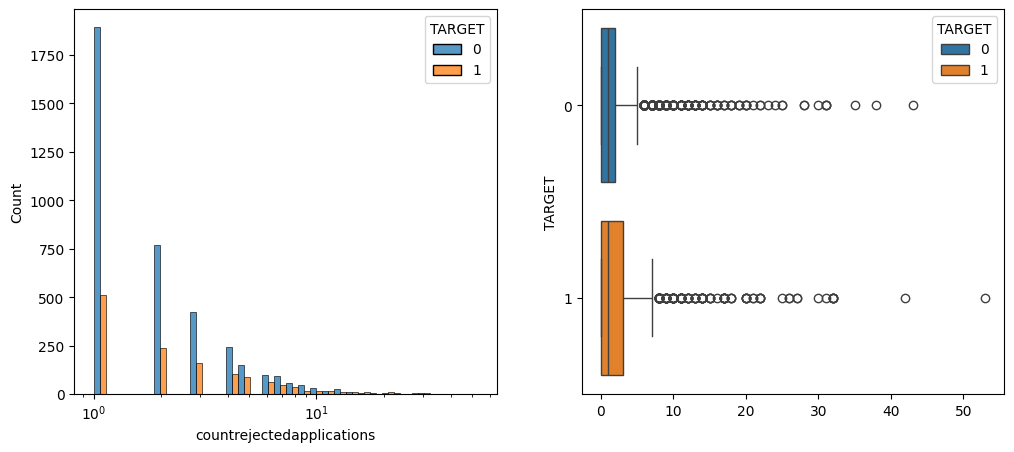

In [ ]:
numeric_plot('countrejectedapplications')

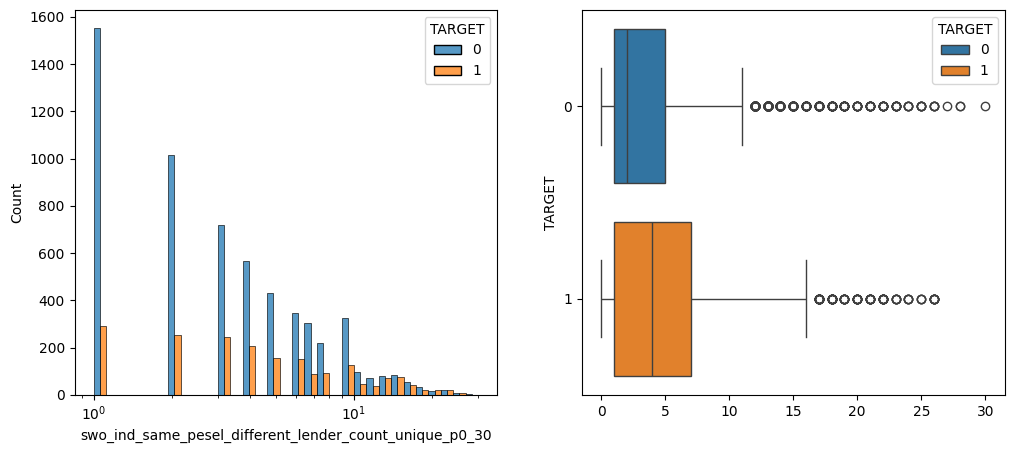

In [ ]:
numeric_plot('swo_ind_same_pesel_different_lender_count_unique_p0_30')

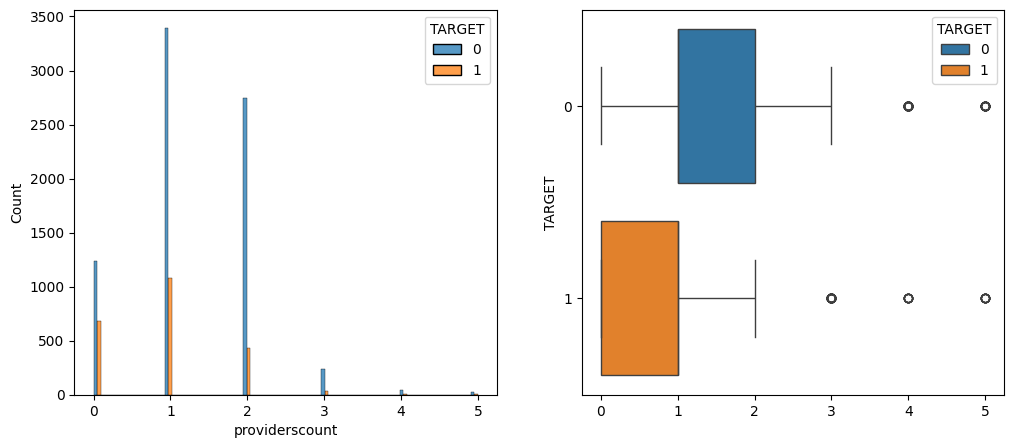

In [ ]:
numeric_plot('providerscount')

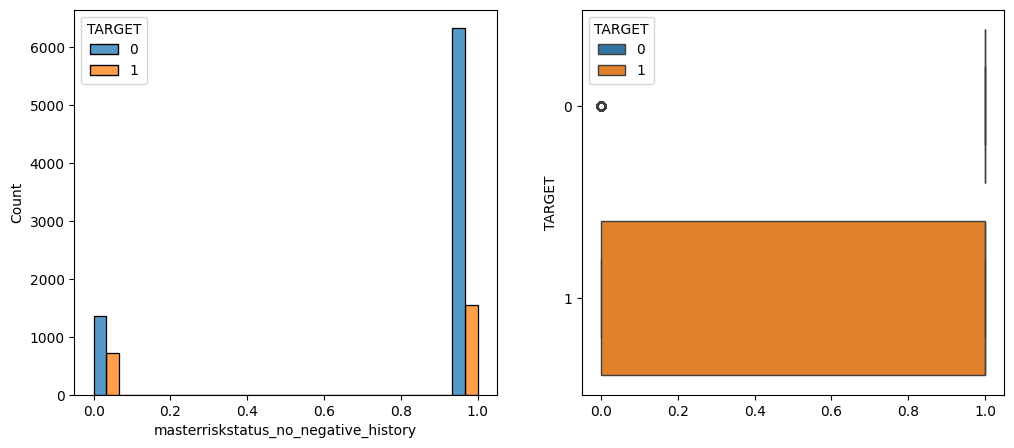

In [ ]:
numeric_plot('masterriskstatus_no_negative_history')

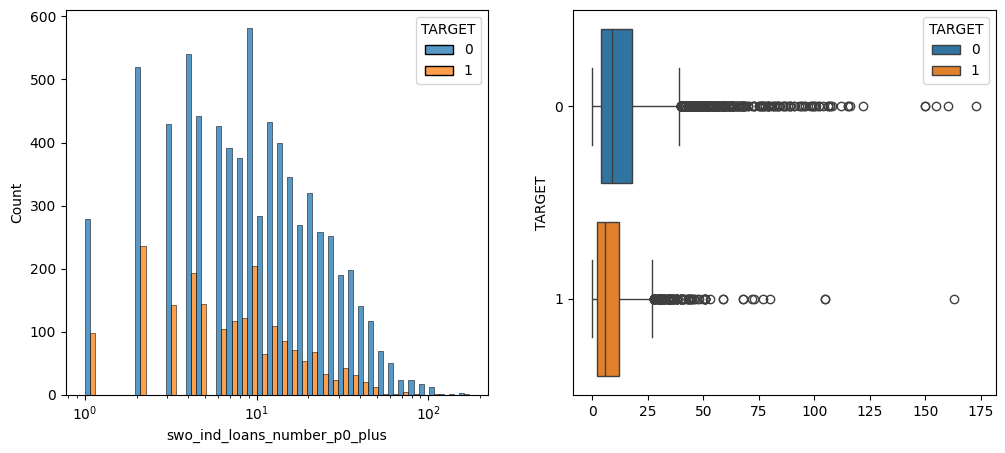

In [ ]:
numeric_plot('swo_ind_loans_number_p0_plus')

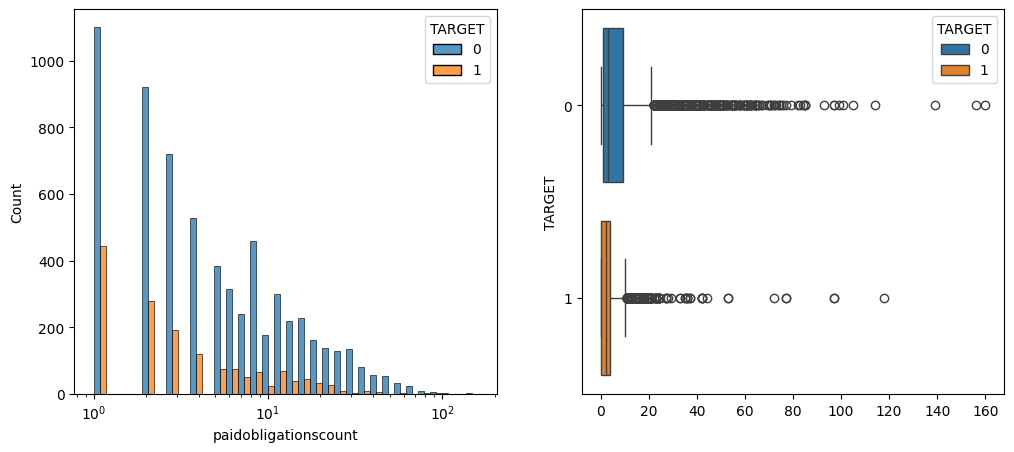

In [ ]:
numeric_plot('paidobligationscount')

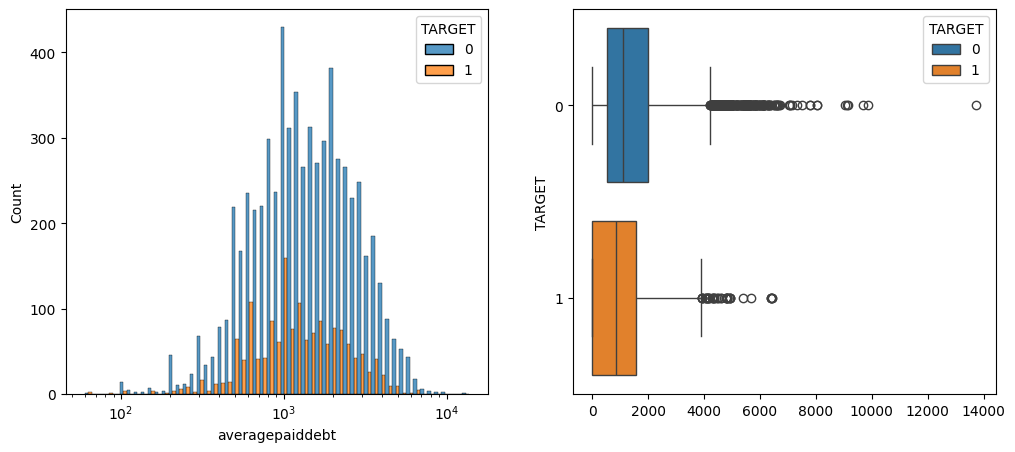

In [ ]:
numeric_plot('averagepaiddebt')